# Reference
- [Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, LSTM, Dense, TimeDistributed
from tf2crf import CRF, ModelWithCRFLoss, ModelWithCRFLossDSCLoss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

import fasttext
import fasttext.util

import helpers
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
# fasttext.util.download_model('en', if_exists='ignore')

# Read Data

In [2]:
# Load Data
train_tokens, train_tags = helpers.read_data('../data/wnut16/train')
test_tokens, test_tags = helpers.read_data('../data/wnut16/test')

train_df = pd.DataFrame({'tokens': train_tokens, 'tags': train_tags})
test_df = pd.DataFrame({'tokens': test_tokens, 'tags': test_tags})

print(train_df.shape, test_df.shape)
train_df.head()

(2394, 2) (3850, 2)


,tokens,tags
0,"[<USR>, <USR>, they, will, be, all, done, by, ...","[O, O, O, O, O, O, O, O, O, O, O, O]"
1,"[Made, it, back, home, to, GA, ., It, sucks, n...","[O, O, O, O, O, B-geo-loc, O, O, O, O, O, O, O..."
2,"[', Breaking, Dawn, ', Returns, to, Vancouver,...","[O, B-movie, I-movie, O, O, O, B-geo-loc, O, O..."
3,"[<USR>, perhaps, ,, but, folks, may, find, som...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[<USR>, aye, been, tonight, -, excellent]","[O, O, O, O, O, O]"


Train Max length: 39
Test Max length: 35


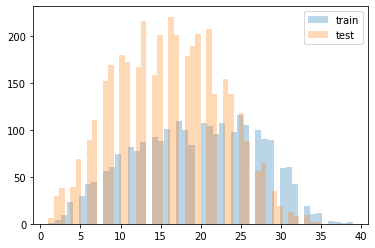

In [3]:
# Length of sequences
train_seq_len = [len(item) for item in train_df['tokens']]
test_seq_len = [len(item) for item in test_df['tokens']]
print(f'Train Max length: {max(train_seq_len)}')
print(f'Test Max length: {max(test_seq_len)}')
plt.hist(train_seq_len, bins=50, alpha=0.3, label='train')
plt.hist(test_seq_len, bins=50, alpha=0.3, label='test')
plt.legend();

# Embeddings

In [4]:
# Constants
emb_size = 300
max_seq_len = 50

ft = fasttext.load_model('../models/cc.en.300.bin') 

In [5]:
# Convert Tokens to Embedding
def get_tok_emb(tokens): 
    emb = np.zeros((max_seq_len, emb_size))
    
    for i, word in enumerate(tokens[:max_seq_len]):
        emb[i] = ft.get_word_vector(word)
    return emb        
    
train_df['tokens_embedding'] = train_df['tokens'].progress_apply(get_tok_emb)
test_df['tokens_embedding'] = test_df['tokens'].progress_apply(get_tok_emb)

train_df.head(2)

100%|██████████| 3850/3850 [00:00<00:00, 5077.61it/s]


,tokens,tags,tokens_embedding
0,"[<USR>, <USR>, they, will, be, all, done, by, ...","[O, O, O, O, O, O, O, O, O, O, O, O]","[[0.026040812954306602, -0.038135215640068054,..."
1,"[Made, it, back, home, to, GA, ., It, sucks, n...","[O, O, O, O, O, B-geo-loc, O, O, O, O, O, O, O...","[[0.13131043314933777, -0.06371604651212692, 0..."


In [6]:
# Convert Tags to Indices
all_unique_tags = np.unique([item for tags in train_tags for item in tags])
tag2index = {value:key+1 for key, value in enumerate(all_unique_tags)}
tag2index['B-PAD'] = 0
index2tag = {key:value for value, key in tag2index.items()}

def get_tag_emb(tags):
    emb = np.zeros((max_seq_len), dtype=int)
    
    for i, tag in enumerate(tags[:max_seq_len]):
        emb[i] = tag2index.get(tag)
    return emb 

train_df['tags_embedding'] = train_df['tags'].progress_apply(get_tag_emb)
test_df['tags_embedding'] = test_df['tags'].progress_apply(get_tag_emb)
train_df.head(2)

100%|██████████| 3850/3850 [00:00<00:00, 131900.66it/s]


,tokens,tags,tokens_embedding,tags_embedding
0,"[<USR>, <USR>, they, will, be, all, done, by, ...","[O, O, O, O, O, O, O, O, O, O, O, O]","[[0.026040812954306602, -0.038135215640068054,...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2..."
1,"[Made, it, back, home, to, GA, ., It, sucks, n...","[O, O, O, O, O, B-geo-loc, O, O, O, O, O, O, O...","[[0.13131043314933777, -0.06371604651212692, 0...","[21, 21, 21, 21, 21, 3, 21, 21, 21, 21, 21, 21..."


# Model

In [7]:
rnn_units = 64
num_tags = len(tag2index)
lr = 0.01

def birnn_crf(max_len_seq, emb_size, rnn_units, num_tags, lr):

    inputs = Input(shape=(max_len_seq, emb_size), dtype='float32')
    output = Bidirectional(GRU(rnn_units, return_sequences=True))(inputs)
    output = CRF(units=num_tags, dtype='float32')(output)
    
    base_model = Model(inputs, output)
    model      = ModelWithCRFLoss(base_model)
    model.compile(optimizer=Adam(lr))
    
    return model

model = birnn_crf(max_seq_len, emb_size, rnn_units, num_tags, lr)

/home/stephenleo/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


# Training

In [8]:
# Split Train and Val
X = train_df['tokens_embedding'].values.tolist()
y = train_df['tags_embedding'].values.tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(np.asarray(X_train).shape, np.asarray(y_train).shape)

(1603, 50, 300) (1603, 50)


In [9]:
np.random.seed(55)
tf.random.set_seed(55)

cp_callback = ModelCheckpoint(filepath='../models/03_bi_lstm_crf/best_model', verbose=1, monitor='val_val_accuracy',
                              mode='max', save_weights_only=False, save_best_only=True)

earlystop = EarlyStopping(monitor='val_val_accuracy', patience=5, verbose=1, mode='max', 
                          baseline=None, restore_best_weights=True)

callbacks = [cp_callback, earlystop]

history = model.fit(x=np.asarray(X_train), y=np.asarray(y_train), 
                    validation_data=(np.asarray(X_val), np.asarray(y_val)), 
                    callbacks=callbacks,
                    epochs=100)

Epoch 1/100
51/51 [==============================] - 10s 110ms/step - loss: 18.1215 - accuracy: 0.9331 - val_loss_val: 5.2787 - val_val_accuracy: 0.9766

Epoch 00001: val_val_accuracy improved from -inf to 0.97656, saving model to ../models/03_bi_lstm_crf/best_model
Epoch 2/100
51/51 [==============================] - 4s 80ms/step - loss: 4.4605 - accuracy: 0.9789 - val_loss_val: 3.9226 - val_val_accuracy: 0.9800

Epoch 00002: val_val_accuracy improved from 0.97656 to 0.97997, saving model to ../models/03_bi_lstm_crf/best_model
Epoch 3/100
51/51 [==============================] - 4s 83ms/step - loss: 3.2365 - accuracy: 0.9823 - val_loss_val: 3.3423 - val_val_accuracy: 0.9808

Epoch 00003: val_val_accuracy improved from 0.97997 to 0.98078, saving model to ../models/03_bi_lstm_crf/best_model
Epoch 4/100
51/51 [==============================] - 4s 79ms/step - loss: 2.5326 - accuracy: 0.9852 - val_loss_val: 3.0431 - val_val_accuracy: 0.9827

Epoch 00004: val_val_accuracy improved from 0.98

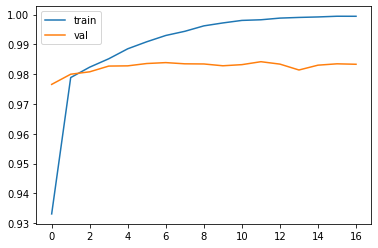

In [10]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_val_accuracy'], label='val')
plt.legend();

# Testing

In [11]:
model = birnn_crf(max_seq_len, emb_size, rnn_units, num_tags, lr)
model.load_weights('../models/03_bi_lstm_crf/best_model')

In [12]:
X_test = np.asarray(test_df['tokens_embedding'].values.tolist())
y_test = np.asarray(test_df['tags_embedding'].values.tolist())

predicted_tags = model.predict(X_test)

In [13]:
def tag_lookup(row):
    len_tags = len(row['tags'])
    pred_tags_embedding = row['pred_tags_embedding'][:len_tags]
    
    return [index2tag.get(idx, 'O') for idx in pred_tags_embedding]

In [14]:
test_df['pred_tags_embedding'] = predicted_tags.tolist()
test_df['pred_tags'] = test_df.apply(tag_lookup, axis=1)
test_df.head(2)

,tokens,tags,tokens_embedding,tags_embedding,pred_tags_embedding,pred_tags
0,"[New, Orleans, Mother, 's, Day, Parade, shooti...","[B-other, I-other, I-other, I-other, I-other, ...","[[0.07400361448526382, -0.1139359399676323, 0....","[6, 16, 16, 16, 16, 16, 21, 21, 21, 21, 21, 21...","[21, 3, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21...","[O, B-geo-loc, O, O, O, O, O, O, O, O, O, O, O..."
1,"[RT, <USR>, :, Going, into, school, tomorrow, ...","[O, O, O, O, O, O, O, O, O, O, O]","[[-0.1761685013771057, 0.21183152496814728, -0...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 0...","[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 0...","[O, O, O, O, O, O, O, O, O, O, O]"


In [16]:
y_true = test_df['tags'].values.tolist()
y_pred = test_df['pred_tags'].values.tolist()

print(f"Overall F1 Score: {f1_score(y_true, y_pred):.2f}")
print("\nClassification Report")
print(classification_report(y_true, y_pred, zero_division=0))

Overall F1 Score: 0.35

Classification Report
              precision    recall  f1-score   support

         PAD       0.00      0.00      0.00         0
     company       0.56      0.37      0.45       621
    facility       0.25      0.09      0.13       253
     geo-loc       0.52      0.60      0.55       882
       movie       0.33      0.03      0.05        34
 musicartist       0.25      0.02      0.03       191
       other       0.20      0.11      0.14       584
      person       0.34      0.59      0.43       482
     product       0.12      0.05      0.07       246
  sportsteam       0.42      0.14      0.21       147
      tvshow       0.00      0.00      0.00        33

   micro avg       0.37      0.34      0.35      3473
   macro avg       0.27      0.18      0.19      3473
weighted avg       0.37      0.34      0.33      3473



# Results

| Dataset | RNN Layer | Hidden Units |  LR  | Overall F1 | Company Precision | Company Recall | Company F1 |
|---------|:---------:|:------------:|:----:|:----------:|:-----------------:|:--------------:|:----------:|
| WNUT16  |  Bi-LSTM  |      64      | 0.01 |    0.36    |        0.50       |      0.42      |    0.45    |
| WNUT16  |  Bi-LSTM  |      128     | 0.01 |    0.35    |        0.52       |      0.39      |    0.45    |
| WNUT16  |   Bi-GRU  |      64      | 0.01 |    0.35    |        0.56       |      0.37      |    0.45    |

# Check predictions

In [17]:
def print_results(index):
    tokens = test_df.iloc[index]['tokens']
    tags = test_df.iloc[index]['tags']
    pred_tags = test_df.iloc[index]['pred_tags']
    
    for idx, token in enumerate(tokens):
        print(f'{token} \t Tag -> {tags[idx]} \t Pred_Tag -> {pred_tags[idx]}')

In [22]:
print_results(4)

<USR> 	 Tag -> O 	 Pred_Tag -> O
Albert 	 Tag -> B-person 	 Pred_Tag -> B-person
Nobbs 	 Tag -> I-person 	 Pred_Tag -> I-person
( 	 Tag -> O 	 Pred_Tag -> O
Glenn 	 Tag -> B-person 	 Pred_Tag -> B-person
Close)is 	 Tag -> O 	 Pred_Tag -> O
a 	 Tag -> O 	 Pred_Tag -> O
woman 	 Tag -> O 	 Pred_Tag -> O
living 	 Tag -> O 	 Pred_Tag -> O
as 	 Tag -> O 	 Pred_Tag -> O
a 	 Tag -> O 	 Pred_Tag -> O
man 	 Tag -> O 	 Pred_Tag -> O
in 	 Tag -> O 	 Pred_Tag -> O
order 	 Tag -> O 	 Pred_Tag -> O
to 	 Tag -> O 	 Pred_Tag -> O
find 	 Tag -> O 	 Pred_Tag -> O
work 	 Tag -> O 	 Pred_Tag -> O
in 	 Tag -> O 	 Pred_Tag -> O
the 	 Tag -> O 	 Pred_Tag -> O
harsh 	 Tag -> O 	 Pred_Tag -> O
environment 	 Tag -> O 	 Pred_Tag -> O
of 	 Tag -> O 	 Pred_Tag -> B-PAD
19th-century 	 Tag -> O 	 Pred_Tag -> B-PAD
Ireland 	 Tag -> B-geo-loc 	 Pred_Tag -> B-PAD


# ---- Backup ----

In [15]:
# def get_scores(true_tags, pred_tags):
#     size = max_seq_len if len(true_tags)>=max_seq_len else len(true_tags)
#     true_tags = true_tags[:size]
#     all_tags = np.unique([true_tags]+[pred_tags])
#     x = classification_report(y_true=true_tags, y_pred=pred_tags, target_names=all_tags, output_dict=True, zero_division=0)
    
#     overall_f1 = x['weighted avg']['f1-score']
#     b_company_f1 = x['B-company']['f1-score'] if 'B-company' in x else np.nan
#     i_company_f1 = x['I-company']['f1-score'] if 'I-company' in x else np.nan
    
#     overall_precision = x['weighted avg']['precision']
#     b_company_precision = x['B-company']['precision'] if 'B-company' in x else np.nan
#     i_company_precision = x['I-company']['precision'] if 'I-company' in x else np.nan
    
#     return pd.Series((overall_f1, b_company_f1, i_company_f1, 
#                       overall_precision, b_company_precision, i_company_precision))

# metric_cols = ['weighted_f1', 'B-company_f1', 'I-company_f1', 
#                'weighted_precision', 'B-company_precision', 'I-company_precision']
# test_df[metric_cols] = test_df.progress_apply(lambda x: get_scores(x['tags'], x['pred_tags']), axis=1)
# test_df.head(2)